<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Module" data-toc-modified-id="Module-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Module</a></span></li><li><span><a href="#Database" data-toc-modified-id="Database-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Database</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model</a></span></li></ul></div>

# Module

In [1]:
# basic
import numpy as np
import pandas as pd

# graphy
import matplotlib.pyplot as plt
%matplotlib inline 

# machine
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# TEJ
import tejapi
tejapi.ApiConfig.api_key = "Your Key"
tejapi.ApiConfig.ignoretz = True

In [2]:
import xgboost as xgb

In [3]:
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Database

https://api.tej.com.tw/columndoc.html?subId=119

In [4]:
df = tejapi.get('TWN/AFF_RAW',
                mdate={'gte': '2000-01-01', 'lte':'2015-12-31'},
                opts={'columns':['coid','mdate','pbr','per','div_yid','mom','str','ltr','profit','invest','dd_merton','dd_kmv','illiq','idiosyncratic','hhi','skew']},
                chinese_column_name = True,
                paginate = True)
df

,證券碼,年月,淨值市價比,益本比,股利殖利率,動能(T-12~T-2),短期反轉(T-1),長期反轉(T-60~T-13),盈利能力(ROE),投資(資產成長率),違約距離(MERTON),違約距離(KMV),流動性,個別風險,產業集中度,偏態係數
None,,,,,,,,,,,,,,,,
0,000116,2000-01-01,1.93,18.71,4.92,4.8539,-8.4057,304.9012,18.36,6.28,2.5780,1.8048,1.2993,2.4401,46.74,0.3433
1,000116,2000-02-01,1.93,18.71,4.92,16.9721,34.1774,232.4449,18.36,6.28,2.7416,1.8113,0.6128,3.6458,46.74,0.3239
2,000116,2000-03-01,1.93,18.71,4.92,40.3105,-12.7359,271.8703,18.36,6.28,2.7144,1.8410,0.6194,1.6831,46.74,0.3356
3,000116,2000-04-01,1.93,18.71,4.92,16.7535,5.1351,289.9844,18.36,6.28,2.6551,1.7888,6.3472,1.9037,46.74,0.3378
4,000116,2000-05-01,1.93,18.71,4.92,7.2224,-6.6836,346.4569,18.36,6.28,2.5556,1.7503,0.9606,2.9572,46.74,0.3952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219686,L2301,2002-06-01,0.87,12.55,1.07,90.2839,1.9022,-51.8333,7.05,-2.97,3.1898,1.6834,0.7113,2.7340,4.06,-0.0216
219687,L2301,2002-07-01,1.73,17.18,4.43,113.0688,-20.9433,-67.1781,9.57,-2.75,2.8559,1.6455,0.9915,2.3022,7.27,-0.0250
219688,L2301,2002-08-01,1.73,17.18,4.43,93.7668,17.6473,-80.3012,9.57,-2.75,3.0223,1.6608,1.0679,2.4797,7.27,-0.0423


In [5]:
df.isnull().sum(axis=0)

證券碼                0
年月                 0
淨值市價比              0
益本比                0
股利殖利率              0
動能(T-12~T-2)       0
短期反轉(T-1)          0
長期反轉(T-60~T-13)    0
盈利能力(ROE)          0
投資(資產成長率)          0
違約距離(MERTON)       0
違約距離(KMV)          0
流動性                0
個別風險               0
產業集中度              0
偏態係數               0
dtype: int64

# Data Lag 1 month

To match return of next month.

In [6]:
# Handle time
from datetime import date, timedelta
import calendar

In [7]:
df['年月'] = df['年月'].apply(lambda x: x + timedelta(days=calendar.monthrange(x.year, x.month)[1])) 

In [8]:
df_label = tejapi.get('TWN/APRCM',
                mdate={'gte': '2000-01-01', 'lte':'2015-12-31'},
                opts = {'columns':['coid','mdate','roi']},
                chinese_column_name = True,
                paginate = True)

df_label['報酬率％_月'] = df_label['報酬率％_月'].apply(lambda x: 1 if x>0 else 0) # 如果報酬率大於0則標記為1，如果小於0則-1
df_label.rename(columns={'證券代碼':'證券碼'}, inplace=True)

In [9]:
df_label

,證券碼,年月,報酬率％_月
None,,,
0,0001,2000-01-01,1
1,0001,2000-02-01,1
2,0001,2000-03-01,1
3,0001,2000-04-01,0
4,0001,2000-05-01,0
...,...,...,...
315128,ZGT50,2015-08-01,0
315129,ZGT50,2015-09-01,1
315130,ZGT50,2015-10-01,1


In [10]:
data = pd.merge(df , df_label, on=['證券碼', '年月'])

In [11]:
data

,證券碼,年月,淨值市價比,益本比,股利殖利率,動能(T-12~T-2),短期反轉(T-1),長期反轉(T-60~T-13),盈利能力(ROE),投資(資產成長率),違約距離(MERTON),違約距離(KMV),流動性,個別風險,產業集中度,偏態係數,報酬率％_月
0,000116,2000-02-01,1.93,18.71,4.92,4.8539,-8.4057,304.9012,18.36,6.28,2.5780,1.8048,1.2993,2.4401,46.74,0.3433,0
1,000116,2000-03-01,1.93,18.71,4.92,16.9721,34.1774,232.4449,18.36,6.28,2.7416,1.8113,0.6128,3.6458,46.74,0.3239,1
2,000116,2000-04-01,1.93,18.71,4.92,40.3105,-12.7359,271.8703,18.36,6.28,2.7144,1.8410,0.6194,1.6831,46.74,0.3356,0
3,000116,2000-05-01,1.93,18.71,4.92,16.7535,5.1351,289.9844,18.36,6.28,2.6551,1.7888,6.3472,1.9037,46.74,0.3378,1
4,000116,2000-06-01,1.93,18.71,4.92,7.2224,-6.6836,346.4569,18.36,6.28,2.5556,1.7503,0.9606,2.9572,46.74,0.3952,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217346,L2301,2002-06-01,0.87,12.55,1.07,68.1692,-2.1275,-45.8614,7.05,-2.97,3.1008,1.6505,0.3460,2.0402,4.06,-0.0027,0
217347,L2301,2002-07-01,0.87,12.55,1.07,90.2839,1.9022,-51.8333,7.05,-2.97,3.1898,1.6834,0.7113,2.7340,4.06,-0.0216,1
217348,L2301,2002-08-01,1.73,17.18,4.43,113.0688,-20.9433,-67.1781,9.57,-2.75,2.8559,1.6455,0.9915,2.3022,7.27,-0.0250,1
217349,L2301,2002-09-01,1.73,17.18,4.43,93.7668,17.6473,-80.3012,9.57,-2.75,3.0223,1.6608,1.0679,2.4797,7.27,-0.0423,0


# Split Dataset

In [12]:
data

,證券碼,年月,淨值市價比,益本比,股利殖利率,動能(T-12~T-2),短期反轉(T-1),長期反轉(T-60~T-13),盈利能力(ROE),投資(資產成長率),違約距離(MERTON),違約距離(KMV),流動性,個別風險,產業集中度,偏態係數,報酬率％_月
0,000116,2000-02-01,1.93,18.71,4.92,4.8539,-8.4057,304.9012,18.36,6.28,2.5780,1.8048,1.2993,2.4401,46.74,0.3433,0
1,000116,2000-03-01,1.93,18.71,4.92,16.9721,34.1774,232.4449,18.36,6.28,2.7416,1.8113,0.6128,3.6458,46.74,0.3239,1
2,000116,2000-04-01,1.93,18.71,4.92,40.3105,-12.7359,271.8703,18.36,6.28,2.7144,1.8410,0.6194,1.6831,46.74,0.3356,0
3,000116,2000-05-01,1.93,18.71,4.92,16.7535,5.1351,289.9844,18.36,6.28,2.6551,1.7888,6.3472,1.9037,46.74,0.3378,1
4,000116,2000-06-01,1.93,18.71,4.92,7.2224,-6.6836,346.4569,18.36,6.28,2.5556,1.7503,0.9606,2.9572,46.74,0.3952,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217346,L2301,2002-06-01,0.87,12.55,1.07,68.1692,-2.1275,-45.8614,7.05,-2.97,3.1008,1.6505,0.3460,2.0402,4.06,-0.0027,0
217347,L2301,2002-07-01,0.87,12.55,1.07,90.2839,1.9022,-51.8333,7.05,-2.97,3.1898,1.6834,0.7113,2.7340,4.06,-0.0216,1
217348,L2301,2002-08-01,1.73,17.18,4.43,113.0688,-20.9433,-67.1781,9.57,-2.75,2.8559,1.6455,0.9915,2.3022,7.27,-0.0250,1
217349,L2301,2002-09-01,1.73,17.18,4.43,93.7668,17.6473,-80.3012,9.57,-2.75,3.0223,1.6608,1.0679,2.4797,7.27,-0.0423,0


In [13]:
X, y = data.iloc[:,2:-1],data.iloc[:,-1]

In [14]:
X

,淨值市價比,益本比,股利殖利率,動能(T-12~T-2),短期反轉(T-1),長期反轉(T-60~T-13),盈利能力(ROE),投資(資產成長率),違約距離(MERTON),違約距離(KMV),流動性,個別風險,產業集中度,偏態係數
0,1.93,18.71,4.92,4.8539,-8.4057,304.9012,18.36,6.28,2.5780,1.8048,1.2993,2.4401,46.74,0.3433
1,1.93,18.71,4.92,16.9721,34.1774,232.4449,18.36,6.28,2.7416,1.8113,0.6128,3.6458,46.74,0.3239
2,1.93,18.71,4.92,40.3105,-12.7359,271.8703,18.36,6.28,2.7144,1.8410,0.6194,1.6831,46.74,0.3356
3,1.93,18.71,4.92,16.7535,5.1351,289.9844,18.36,6.28,2.6551,1.7888,6.3472,1.9037,46.74,0.3378
4,1.93,18.71,4.92,7.2224,-6.6836,346.4569,18.36,6.28,2.5556,1.7503,0.9606,2.9572,46.74,0.3952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217346,0.87,12.55,1.07,68.1692,-2.1275,-45.8614,7.05,-2.97,3.1008,1.6505,0.3460,2.0402,4.06,-0.0027
217347,0.87,12.55,1.07,90.2839,1.9022,-51.8333,7.05,-2.97,3.1898,1.6834,0.7113,2.7340,4.06,-0.0216
217348,1.73,17.18,4.43,113.0688,-20.9433,-67.1781,9.57,-2.75,2.8559,1.6455,0.9915,2.3022,7.27,-0.0250
217349,1.73,17.18,4.43,93.7668,17.6473,-80.3012,9.57,-2.75,3.0223,1.6608,1.0679,2.4797,7.27,-0.0423


In [15]:
y

0         0
1         1
2         0
3         1
4         0
         ..
217346    0
217347    1
217348    1
217349    0
217350    1
Name: 報酬率％_月, Length: 217351, dtype: int64

#  Model

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

numpy 版本太新會無法執行
https://blog.csdn.net/qq_33731081/article/details/103826931

分類器

In [17]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [18]:
model = XGBClassifier(use_label_encoder=False)
model.fit(X_train, y_train)

[16:35:04] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [19]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [20]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 54.87%


# Prediction 

In [22]:
df_pred = tejapi.get('TWN/AFF_RAW',
                coid = '2330',
                mdate={'gte': '2015-12-01', 'lte':'2017-11-30'},
                opts={'columns':['coid','mdate','pbr','per','div_yid','mom','str','ltr','profit','invest','dd_merton','dd_kmv','illiq','idiosyncratic','hhi','skew']},
                chinese_column_name = True,
                paginate = True)

,證券碼,年月,淨值市價比,益本比,股利殖利率,動能(T-12~T-2),短期反轉(T-1),長期反轉(T-60~T-13),盈利能力(ROE),投資(資產成長率),違約距離(MERTON),違約距離(KMV),流動性,個別風險,產業集中度,偏態係數
None,,,,,,,,,,,,,,,,
0,2330,2015-12-01,3.49,13.86,3.20,-0.3997,1.8315,153.5243,34.52,18.37,10.6615,3.7167,0.0342,0.6328,980.75,0.4064
1,2330,2016-01-01,3.49,13.86,3.20,1.7841,2.8779,125.5866,34.52,18.37,10.7956,3.7334,0.0252,0.6965,980.75,0.3692
2,2330,2016-02-01,3.49,13.86,3.20,4.7134,-0.6995,109.9167,34.52,18.37,11.0696,3.8343,0.0246,0.9712,980.75,0.4260
3,2330,2016-03-01,3.49,13.86,3.20,-2.5826,4.9295,142.4932,34.52,18.37,11.3502,3.8783,0.0196,1.0246,980.75,0.4314
4,2330,2016-04-01,3.49,13.86,3.20,5.7322,8.7248,134.1049,34.52,18.37,12.0069,4.0075,0.0154,0.5574,980.75,0.4359
5,2330,2016-05-01,3.49,13.86,3.20,13.7841,-7.4075,128.1177,34.52,18.37,11.9407,4.0696,0.0219,0.7402,980.75,0.4056
6,2330,2016-06-01,3.49,13.86,3.20,6.0772,4.3331,116.2267,34.52,18.37,11.8717,4.0004,0.0165,0.8353,980.75,0.3981
7,2330,2016-07-01,3.04,12.10,3.69,11.3871,7.8403,119.0314,30.28,10.87,11.7313,3.9540,0.0230,0.5601,1164.87,0.2984
8,2330,2016-08-01,3.04,12.10,3.69,20.9815,6.1538,118.0766,30.28,10.87,11.9066,3.9491,0.0188,0.7415,1164.87,0.2855


In [23]:
df_pred_label = tejapi.get('TWN/APRCM',
                coid = comp,
                mdate={'gte': '2016-01-01', 'lte':'2017-12-31'},
                opts = {'columns':['mdate','roi']},
                chinese_column_name = True,
                paginate = True)
df_pred_label

,年月,報酬率％_月
None,,
0,2016-01-01,-0.6995
1,2016-02-01,4.9295
2,2016-03-01,8.7248
3,2016-04-01,-7.4075
4,2016-05-01,4.3331
5,2016-06-01,7.8403
6,2016-07-01,6.1538
7,2016-08-01,2.0290
8,2016-09-01,3.6929


In [24]:
pred2 = model.predict(df_pred.iloc[:,2:])
df_pred_label['報酬率預測'] = pred2
df_pred_label

,年月,報酬率％_月,報酬率預測
None,,,
0,2016-01-01,-0.6995,1
1,2016-02-01,4.9295,1
2,2016-03-01,8.7248,1
3,2016-04-01,-7.4075,0
4,2016-05-01,4.3331,0
5,2016-06-01,7.8403,1
6,2016-07-01,6.1538,0
7,2016-08-01,2.0290,1
8,2016-09-01,3.6929,1


In [25]:
accuracy = accuracy_score(df_pred_label['報酬率％_月'].apply(lambda x: 1 if x>0 else 0), pred2)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 70.83%


# Visualize Boosting Trees and Feature Importance

In [26]:
import matplotlib.pyplot as plt
import matplotlib.font_manager
plt.rcParams['font.sans-serif'] = 'Arial Unicode MS'
plt.rcParams['axes.unicode_minus'] = False

<Figure size 2160x720 with 0 Axes>

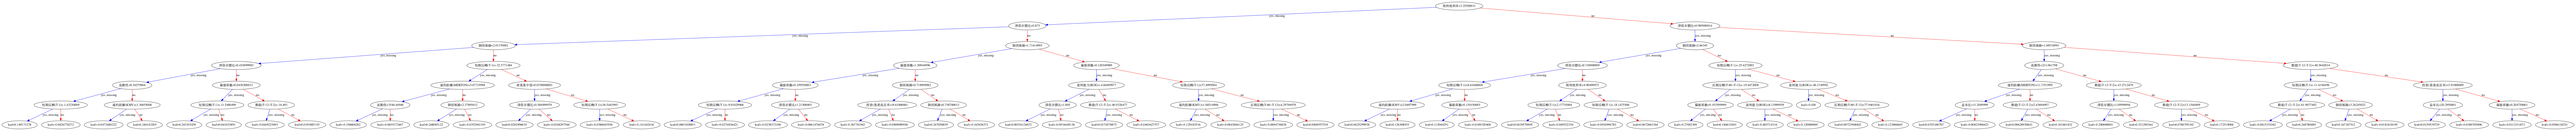

In [32]:
plt.figure(figsize=(30,10))
xgb.plot_tree(model,num_trees=0)
plt.rcParams['figure.figsize'] = [1300, 1000]
plt.show()

<Figure size 720x2880 with 0 Axes>

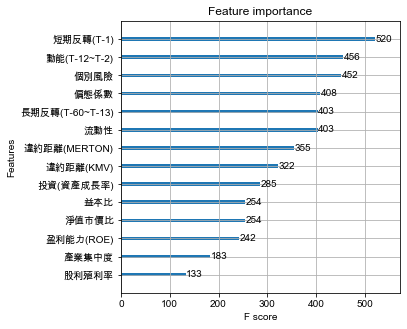

In [34]:
plt.figure(figsize=(10,40))
xgb.plot_importance(model)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()